In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [32]:
end_date = datetime.strptime('2024-12-17', '%Y-%m-%d')
start_date = end_date - timedelta(days=27) # Для CUPED
begin_date = end_date - timedelta(days=13) # Начало теста
query = f'''
WITH users AS (SELECT 
               user_id,
               reg_date,
               created_date,
               bonus_title_new,
               JSONExtractString(JSONExtractString(payload,'flags'),'new_button_main_page') AS flags,
               CASE WHEN created_date='1970-01-01' THEN 0 ELSE 1 END trial_type,
               max(app_version) AS app_version
               FROM
                (SELECT user_id,payload,app_version,created_at::date AS created_date,reg_date,bonus_title
                 FROM datamarts.sandbox_data_distr 
                 WHERE reg_date BETWEEN '{start_date.date()}' AND '{end_date.date()}'
                 AND user_id IS NOT NULL
                 AND client_type IN ('web_desktop','web_mobile')
                 ) AS t1
                LEFT JOIN datamarts.mekhtiev_bonus_distr AS t2 ON t1.bonus_title=t2.bonus_title_old
                GROUP BY 1,2,3,4,5,6
            ),
                
---Дедуппликация пользователей с несколькими группами --------
duplicate AS (SELECT user_id,uniq(flags) AS cnt_uniq_flag
                FROM users
                WHERE flags!=''
                GROUP BY 1
                )
                
-------Убираем дубликаты и джойним ----------                
SELECT 
t1.user_id AS user_id,
reg_date,
bonus_title_new,
created_date,
app_version,
trial_type,
flags
FROM users AS t1
LEFT JOIN (SELECT * FROM duplicate WHERE cnt_uniq_flag>1) AS t2 ON t1.user_id=t2.user_id
WHERE t2.user_id IS NULL
'''

df = execute(query,user='kmekhtiev')
df['reg_date'] = df['reg_date'].astype('datetime64[ns]')

Время выполнения функции: 8.6725 секунд



In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27721 entries, 0 to 27720
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          27721 non-null  object        
 1   reg_date         27721 non-null  datetime64[ns]
 2   bonus_title_new  27721 non-null  object        
 3   created_date     27721 non-null  object        
 4   app_version      27721 non-null  object        
 5   trial_type       27721 non-null  int64         
 6   flags            27721 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.5+ MB


In [36]:
df['reg_date'].unique()

<DatetimeArray>
['2024-12-06 00:00:00', '2024-11-26 00:00:00', '2024-11-24 00:00:00',
 '2024-12-02 00:00:00', '2024-12-10 00:00:00', '2024-11-25 00:00:00',
 '2024-11-20 00:00:00', '2024-12-15 00:00:00', '2024-11-29 00:00:00',
 '2024-12-12 00:00:00', '2024-11-21 00:00:00', '2024-11-27 00:00:00',
 '2024-12-05 00:00:00', '2024-11-30 00:00:00', '2024-12-16 00:00:00',
 '2024-12-14 00:00:00', '2024-12-08 00:00:00', '2024-11-23 00:00:00',
 '2024-11-28 00:00:00', '2024-12-04 00:00:00', '2024-12-03 00:00:00',
 '2024-12-09 00:00:00', '2024-12-13 00:00:00', '2024-12-07 00:00:00',
 '2024-12-01 00:00:00', '2024-12-11 00:00:00', '2024-11-22 00:00:00',
 '2024-12-17 00:00:00']
Length: 28, dtype: datetime64[ns]

In [38]:
test_df = df[df['reg_date']>=begin_date] # Датафрейм для периода эксперимента

In [40]:
test_df['flags'].unique()

array(['group_a', 'group_b'], dtype=object)

In [42]:
counts = pd.DataFrame({'cnt_user': [test_df['user_id'].count(), test_df[test_df['trial_type'] == 1]['user_id'].count()]})  

counts['percentage'] = round(counts['cnt_user'] / counts.iloc[0,0] * 100,2)

counts

,cnt_user,percentage
0,12969,100.00
1,3701,28.54


In [46]:
test_df['reg_date'].unique()

<DatetimeArray>
['2024-12-06 00:00:00', '2024-12-10 00:00:00', '2024-12-15 00:00:00',
 '2024-12-12 00:00:00', '2024-12-05 00:00:00', '2024-12-16 00:00:00',
 '2024-12-14 00:00:00', '2024-12-08 00:00:00', '2024-12-04 00:00:00',
 '2024-12-09 00:00:00', '2024-12-13 00:00:00', '2024-12-07 00:00:00',
 '2024-12-11 00:00:00', '2024-12-17 00:00:00']
Length: 14, dtype: datetime64[ns]

In [50]:
t = test_df.groupby('trial_type')['user_id'].count().reset_index()  
t.columns = ['trial_type', 'cnt_user']
t

,trial_type,cnt_user
0,0,9268
1,1,3701


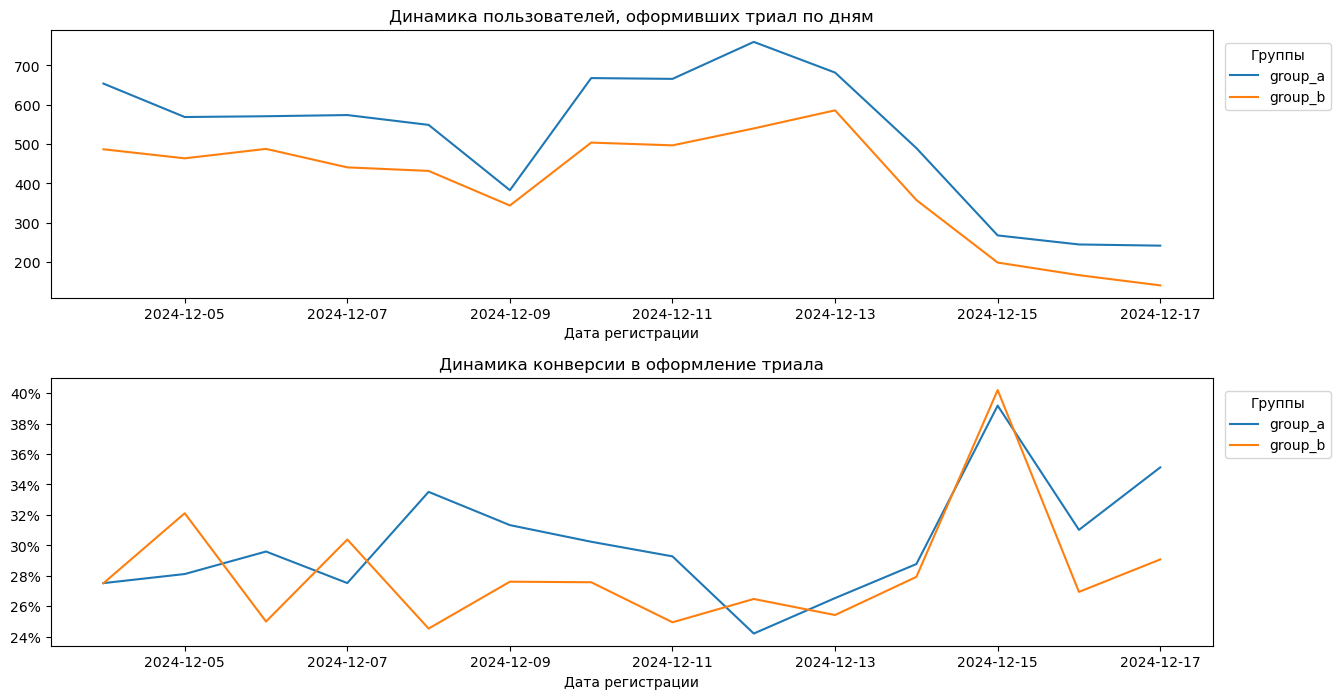

In [52]:
df_agg = test_df.groupby(['reg_date','flags'],as_index=False).agg({'user_id':'nunique','trial_type':'sum'})
df_agg['conv'] = df_agg['trial_type']/df_agg['user_id']

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.lineplot(data=df_agg,x='reg_date',y='user_id',hue='flags', ax=ax[0])
ax[0].set_title("Динамика пользователей, оформивших триал по дням")
ax[0].set_xlabel('Дата регистрации')
ax[0].set_ylabel('')
ax[0].legend(title='Группы',loc=(1.01,0.7))


sns.lineplot(data=df_agg,x='reg_date',y='conv',hue='flags',ax=ax[1])
ax[1].set_title("Динамика конверсии в оформление триала")
ax[1].set_xlabel('Дата регистрации')
ax[1].set_ylabel('')
ax[1].legend(title='Группы',loc=(1.01,0.7))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

plt.subplots_adjust(hspace=0.3)
plt.show()  

In [54]:
df

,user_id,reg_date,bonus_title_new,created_date,app_version,trial_type,flags
0,cee7450c-6e6c-4c2c-9136-5b8b5c2ea3a0,2024-12-06,,1970-01-01,4.12.1-prod,0,group_a
1,36b92c6b-1112-4933-9f6a-3206748ba1ae,2024-11-26,Flocktory,2024-11-26,4.11.1-prod,1,
2,e3a9f92c-4e3c-4154-a128-7b1bc19f8860,2024-11-24,,1970-01-01,4.11.1-prod,0,
3,fafc3c43-6da7-44d0-95b5-5be822fc5a74,2024-12-02,Flocktory,2024-12-02,4.11.1-prod,1,
4,0e9a2e23-55ed-4b3c-8fc1-95fcae52dc4a,2024-12-10,,1970-01-01,4.12.1-prod,0,group_b
...,...,...,...,...,...,...,...
27716,4303ac47-0414-495e-8a3f-e1d209f43e12,2024-12-06,,1970-01-01,4.12.1-prod,0,group_b
27717,ca3a29e6-86c0-4e49-89fe-0ab69baa18f5,2024-11-29,,1970-01-01,4.11.1-prod,0,
27718,124d1439-7074-437f-be98-0b846cefb735,2024-11-20,,1970-01-01,4.11.1-prod,0,
27719,3febdf8b-7a84-4bc4-be7d-1d82a971c065,2024-12-09,Ставропольцев,2024-12-09,4.12.1-prod,1,group_a


In [56]:
control_group = 'group_a'
test_group_1 = 'group_b'

control = test_df[test_df['flags']==control_group]
test_1 = test_df[test_df['flags']==test_group_1]

parameter = 'trial_type' # Целевая метрика для эксперимента.  Нужно для функций по постстратификации

num_of_bucket = 2

BOLD = "\033[1m"  
END = "\033[0m" 

In [58]:
test_df[test_df['trial_type']==1]['user_id'].count()/test_df['user_id'].count()


0.28537281209036935

## Тест на независимость 

In [61]:
# Функция для хи-квадра по определению независимости между выборками
def chi_independence(df, control, test_1, segment_name, part=None):
        '''H0: distributions are independent, H1: distributions are dependent '''
        for segment in segment_name:
                control1 = df[df['flags'] == control][segment].value_counts()
                test1 = df[df['flags'] == test_1][segment].value_counts()
                # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
                # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
                
                #concat = pd.concat([control1,test1,test2,test3], axis=1)
                #concat.columns = ['control_1','test_1','test_2','test_3']
                concat = pd.concat([control1,test1], axis=1)
                concat.columns = ['control','test_1']
                if part:
                    print(concat.iloc[:part])
                    stat, p_value, dof, expected = stats.chi2_contingency(concat.iloc[:part])
                else:
                    stat, p_value, dof, expected = stats.chi2_contingency(concat)

                if p_value <= 0.01:
                        print (f" {segment}- p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, dependent (reject H0)\n")
                else:
                        print (f" {segment} - p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, independent (fail to reject H0)\n")


In [63]:
chi_independence(test_df,
                  control_group,
                  test_group_1,
                 ['bonus_title_new','app_version'],
                 15
                )

                                    control  test_1
bonus_title_new                                    
                                     6607.0  5135.0
Яндекс Директ. 1 месяц за 1 рубль.    263.0   207.0
Flocktory                             209.0   135.0
RIS                                    75.0    50.0
30 дней за 1 рубль. MediaNation        40.0    23.0
Ставропольцев                          36.0    26.0
test                                   28.0    19.0
VIJU29                                 24.0    14.0
Get4Click                              13.0    18.0
Sharry 3 мес 399 \ 45 дней             10.0     7.0
PROMO35                                 5.0     7.0
Perfluence                              5.0     3.0
Mobile                                  2.0     2.0
14 дней за 1 рубль.  Промостраницы      1.0     1.0
email                                   1.0     NaN
 bonus_title_new - p-value: nan, statistic: nan, dof: 14, independent (fail to reject H0)

             control  tes

## Тест на SRM (тест на однородность)

In [66]:
def chi_homogeneity(df, control, test_1, segment_name,number_of_groups, part=None):
    '''H0: distributions are homogeneous, H1: distributions are not homogeneous '''
    for segment in segment_name:
            control1 = df[df['flags'] == control][segment].value_counts()
            test1 = df[df['flags'] == test_1][segment].value_counts()
            # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
            # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
            concat = pd.concat([control1,test1], axis=1)
            concat.columns = ['control_1','test_1']
            concat['expected']=concat.sum(axis=1).apply(lambda x: math.ceil(x / number_of_groups))
            print(concat.iloc[:part])
            for i in concat.columns[:-1]:
                    # рассчитываем статистику
                    k = len(concat[i].iloc[:part])                                                                                             # число степеней свободы 
                    statistic = (((concat[i].iloc[:part] - concat['expected'].iloc[:part])**2)/concat['expected'].iloc[:part]).sum()           # КСП
                    # рассчитываем p-value 
                    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                                                                             # вероятность получить значение выше или равное статистике
                    if p_value <= 0.01:
                            print (f" {segment}- p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, homogenes (reject H0)\n")
                    else:
                            print (f" {segment} - p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, not homogenes (fail to reject H0)\n")


In [68]:
chi_homogeneity(test_df,
                  control_group,
                  test_group_1,
                 segment_name = ['bonus_title_new','app_version'],
                 number_of_groups = 2,
                 part = 10
                )

                                    control_1  test_1  expected
bonus_title_new                                                
                                       6607.0  5135.0      5871
Яндекс Директ. 1 месяц за 1 рубль.      263.0   207.0       235
Flocktory                               209.0   135.0       172
RIS                                      75.0    50.0        63
30 дней за 1 рубль. MediaNation          40.0    23.0        32
Ставропольцев                            36.0    26.0        31
test                                     28.0    19.0        24
VIJU29                                   24.0    14.0        19
Get4Click                                13.0    18.0        16
Sharry 3 мес 399 \ 45 дней               10.0     7.0         9
 bonus_title_new- p-value: 0.0000, statistic: 111.3101, dof: 9, homogenes (reject H0)

 bonus_title_new- p-value: 0.0000, statistic: 112.6340, dof: 9, homogenes (reject H0)

             control_1  test_1  expected
app_version      

## Постстратификация

In [71]:
def calculate_stratified_mean(df, weights,parameter):
    strat_mean = df.groupby('bonus_title_new')[parameter].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights[parameter]).sum()
    return mean_strat

In [73]:
def calculate_strat_var(df, weights, parameter):
    """Вычисляет стратифицированную дисперсию."""
    """ Parametr - поле конверсии """
    strat_vars = df.groupby('bonus_title_new')[parameter].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights[parameter]).sum()
    return var_strat

In [75]:
def check_stratified_test(df_control, df_pilot, weights, parameter):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего."""
    mean_strat_control = calculate_stratified_mean(df_control, weights, parameter)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights, parameter)
    var_strat_control = calculate_strat_var(df_control, weights, parameter)
    var_strat_pilot = calculate_strat_var(df_pilot, weights, parameter)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [77]:
weights = test_df['bonus_title_new'].value_counts(normalize=True).to_dict()

print(calculate_strat_var(test_df,weights,'trial_type'))
print(test_df['trial_type'].var())
print(test_df['trial_type'].mean())

0.15058237483079956
0.20395089624097767
0.28537281209036935


In [79]:
test_df[test_df['bonus_title_new']=='']['trial_type'].var()

0.1663177328547612

## Симмуляция Монте-Карло для контроля ошибок I и II рода

In [82]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
    """ Учитываем поправку на множественное тестирование и снижаем альфу по методу Бонферрони """
    t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = var * 2
    MDE=(t_alpha+t_beta) * np.sqrt(var / ttl_users)
    return MDE

In [84]:
ttl_users = math.ceil(test_df['user_id'].count() / num_of_bucket)
var = test_df[parameter].var()
mean = test_df[parameter].mean()

mde_absolute = mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean
print(f"{BOLD}Период(дни) - 7 {END}") 
print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Среднияя конверсия в отписку:',round(mean,4))
print('Дисперсия:',round(var,4))
print('Число пользователей в группе:',math.ceil(ttl_users))

Период(дни) - 7 
MDE абсолютный: 0.0222
MDE относительный: 0.0779
Среднияя конверсия в отписку: 0.2854
Дисперсия: 0.204
Число пользователей в группе: 6485


In [86]:
ttl_users = math.ceil(test_df['user_id'].count() / num_of_bucket)
var = calculate_strat_var(test_df, weights, parameter = parameter)
mean_strat = calculate_stratified_mean(test_df, weights, parameter = parameter) # Стратицированное выборочное среднее 
mean = test_df['trial_type'].mean() # обычное выборочное среднее

mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean
print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средняя конверсия в триал за неделю:',round(mean,4))
print('Дисперсия:',round(var,4)) 
print('Число пользователей в группе:',math.ceil(ttl_users))

MDE абсолютный: 0.0191
MDE относительный: 0.0669
Средняя конверсия в триал за неделю: 0.2854
Дисперсия: 0.1506
Число пользователей в группе: 6485


100%|██████████| 1000/1000 [00:00<00:00, 1155.55it/s]



Эффект = 0
Период (дни) - 7 дней
Итераций с p_value < 0.05: 43
Число пользователей всего: 12970

Эффект = 0.1064
Период (дни) - 7 дней
Итераций с p_value < 0.05: 964
Число пользователей всего: 12970


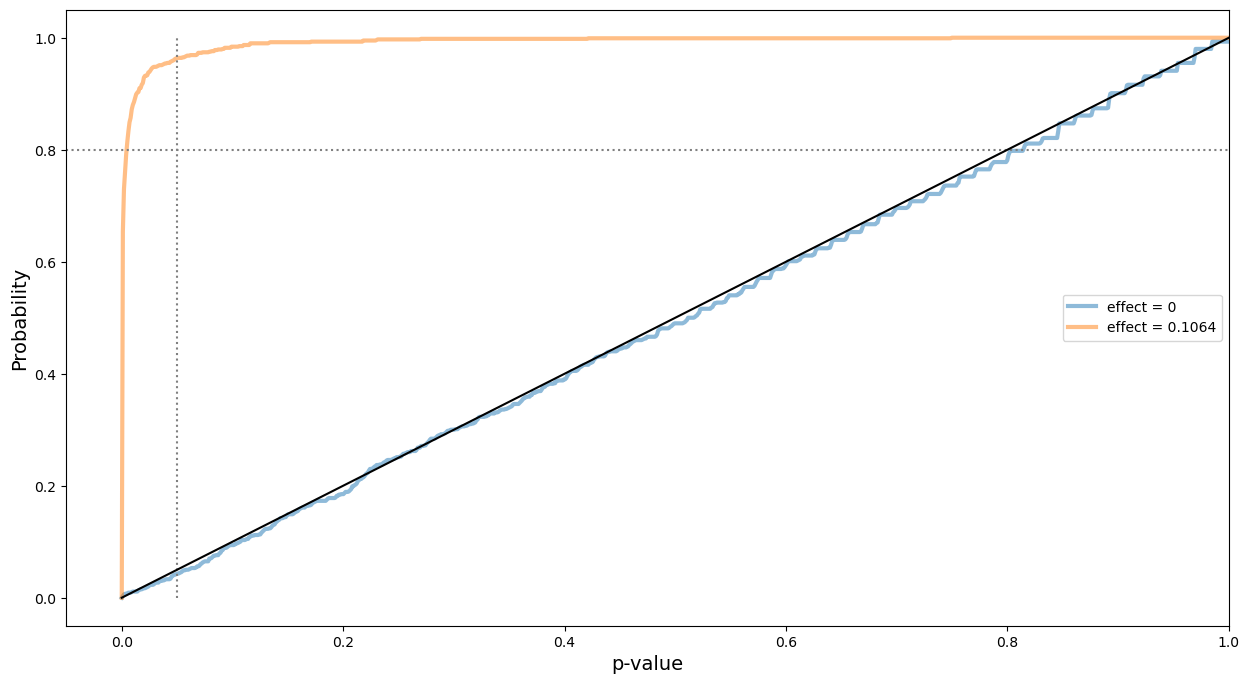

In [88]:
effects = [0,0.1064] # Относительный эффект

# Хранение p-values для каждого значения эффекта
pvalues_dict = {}


for effect in effects:
    ttl_users = math.ceil(test_df['user_id'].nunique() / num_of_bucket)
    pvalues_ttest = []
    for i in tqdm(range(1000)):
    
        df_control = test_df.sample(n=ttl_users, replace=True)
        df_pilot = test_df.sample(n=ttl_users, replace=True)
        df_pilot = df_pilot[parameter] * (1 + effect)

        # Проведение t-теста
        _,p_value = ttest_ind(df_control[parameter], df_pilot)
        pvalues_ttest.append(p_value)
        
    pvalues_dict[effect] = pvalues_ttest  # Сохраняем p-values для текущего эффекта
        

# Визуализация результатов
plt.figure(figsize=(15, 8))
X = np.linspace(0, 1, 1000)

for effect, pvalues in pvalues_dict.items():
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=f'effect = {effect}')
    print()
    print(f"Эффект = {effect}")
    print(f"Период (дни) - 7 дней")
    print(f'Итераций с p_value < 0.05:', len([p for p in pvalues if p < 0.05]))
    print(f'Число пользователей всего:', ttl_users * 2)

plt.xlabel('p-value', size=14)
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Подсчет среднего и критериев

In [91]:
cr_control = calculate_stratified_mean(control, weights, parameter = parameter)
cr_test = calculate_stratified_mean(test_1, weights, parameter = parameter)
test_to_control = check_stratified_test(control, test_1, weights, parameter = parameter)

In [93]:
calculate_stratified_mean(control, weights, parameter = parameter)

0.2899672846186821

In [95]:
final_table_register = []

row1 = [cr_control, cr_test, test_to_control]
#row2 = [next_step_after_scare_cr_control, next_step_after_scare_cr_test, next_step_after_scare_test_to_control]

final_table_register.append(row1)
#final_table_register.append(row2)



final_table_register = pd.DataFrame(final_table_register, index=['Конверсия в оформление пробного периода'], columns=['Контроль', 'Тест', 'p_value'])
final_table_register['Тест к контролю (%)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] / final_table_register['Контроль'] - 1) * 100,3), 'Нет различия'))
final_table_register['Тест к контролю (п.п.)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] - final_table_register['Контроль']),3), 'Нет различия'))
final_table_register[['Контроль','Тест']] = final_table_register[['Контроль','Тест']].round(3).astype('str')

final_table_register

,Контроль,Тест,p_value,Тест к контролю (%),Тест к контролю (п.п.)
Конверсия в оформление пробного периода,0.29,0.279,0.117048,Нет различия,Нет различия


### Функция закраски

In [98]:
def color_cell(val):
    if val == 'Нет различия':
        return ''
    elif '+' in val:
        return 'background-color: lightgreen'
    else:
        return 'background-color:  #FFCCCB'

In [100]:
final_table_register[['Контроль', 'Тест','Тест к контролю (%)', 'Тест к контролю (п.п.)']].style.applymap(color_cell, subset=['Тест к контролю (%)','Тест к контролю (п.п.)'])

,Контроль,Тест,Тест к контролю (%),Тест к контролю (п.п.)
Конверсия в оформление пробного периода,0.29,0.279,Нет различия,Нет различия


## Посмотрим отдельно  web_mobile и web_desktop

In [105]:
end_date = datetime.strptime('2024-12-17', '%Y-%m-%d')
start_date = end_date - timedelta(days=27) # Для CUPED
begin_date = end_date - timedelta(days=13) # Начало теста
query = f'''
WITH users AS (SELECT 
               user_id,
               reg_date,
               created_date,
               bonus_title_new,
               client_type,
               JSONExtractString(JSONExtractString(payload,'flags'),'new_button_main_page') AS flags,
               CASE WHEN created_date='1970-01-01' THEN 0 ELSE 1 END trial_type,
               max(app_version) AS app_version
               FROM
                (SELECT user_id,payload,app_version,created_at::date AS created_date,reg_date,bonus_title,client_type
                 FROM datamarts.sandbox_data_distr 
                 WHERE reg_date BETWEEN '{start_date.date()}' AND '{end_date.date()}'
                 AND user_id IS NOT NULL
                 AND client_type IN ('web_desktop','web_mobile')
                 ) AS t1
                LEFT JOIN datamarts.mekhtiev_bonus_distr AS t2 ON t1.bonus_title=t2.bonus_title_old
                GROUP BY 1,2,3,4,5,6,7
            ),
                
---Дедуппликация пользователей с несколькими группами --------
duplicate AS (SELECT user_id,uniq(flags) AS cnt_uniq_flag
                FROM users
                WHERE flags!=''
                GROUP BY 1
                )
                
-------Убираем дубликаты и джойним ----------                
SELECT 
t1.user_id AS user_id,
reg_date,
bonus_title_new,
client_type,
created_date,
app_version,
trial_type,
flags
FROM users AS t1
LEFT JOIN (SELECT * FROM duplicate WHERE cnt_uniq_flag>1) AS t2 ON t1.user_id=t2.user_id
WHERE t2.user_id IS NULL
'''

df = execute(query,user='kmekhtiev')
df['reg_date'] = df['reg_date'].astype('datetime64[ns]')

Время выполнения функции: 6.1874 секунд



In [117]:
test_df = df[df['reg_date']>=begin_date] # Датафрейм для периода эксперимента

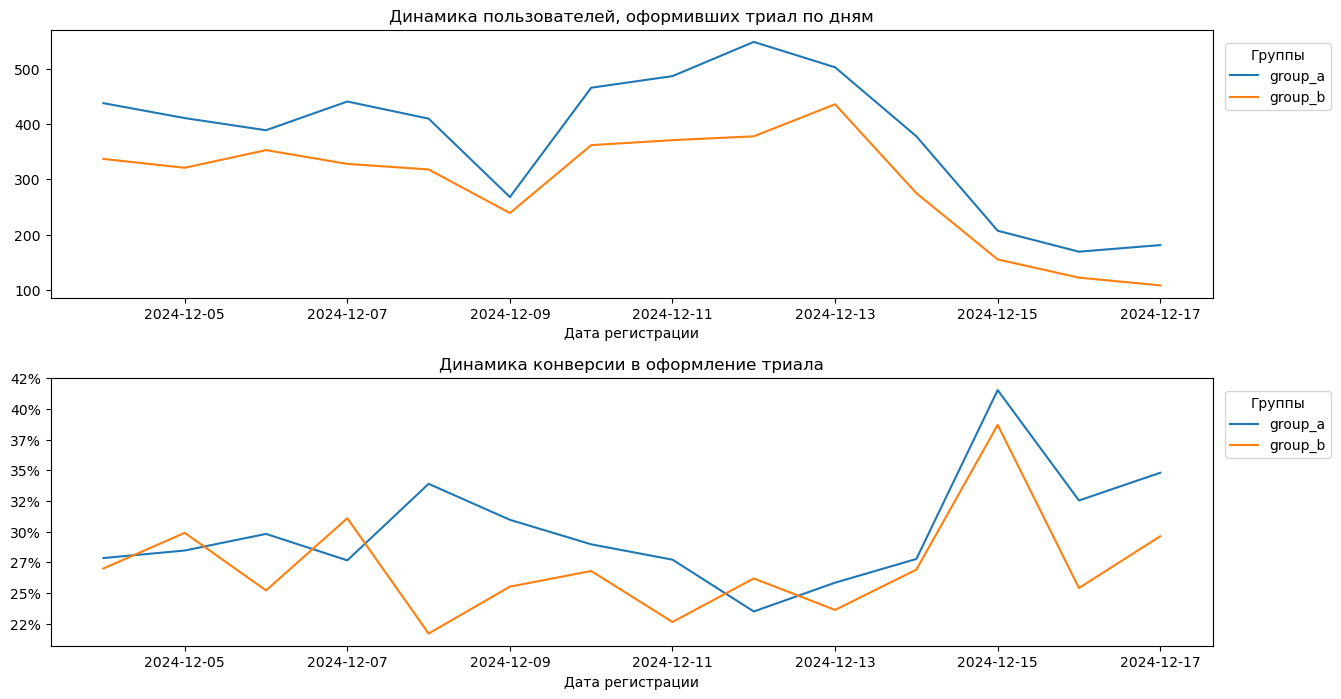

In [119]:
df_agg = test_df[test_df['client_type']=='web_mobile'].groupby(['reg_date','flags'],as_index=False).agg({'user_id':'nunique','trial_type':'sum'})
df_agg['conv'] = df_agg['trial_type']/df_agg['user_id']

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.lineplot(data=df_agg,x='reg_date',y='user_id',hue='flags', ax=ax[0])
ax[0].set_title("Динамика пользователей web_mobile, оформивших триал по дням")
ax[0].set_xlabel('Дата регистрации')
ax[0].set_ylabel('')
ax[0].legend(title='Группы',loc=(1.01,0.7))


sns.lineplot(data=df_agg,x='reg_date',y='conv',hue='flags',ax=ax[1])
ax[1].set_title("Динамика конверсии в оформление триала в web_mobile")
ax[1].set_xlabel('Дата регистрации')
ax[1].set_ylabel('')
ax[1].legend(title='Группы',loc=(1.01,0.7))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

plt.subplots_adjust(hspace=0.3)
plt.show()  

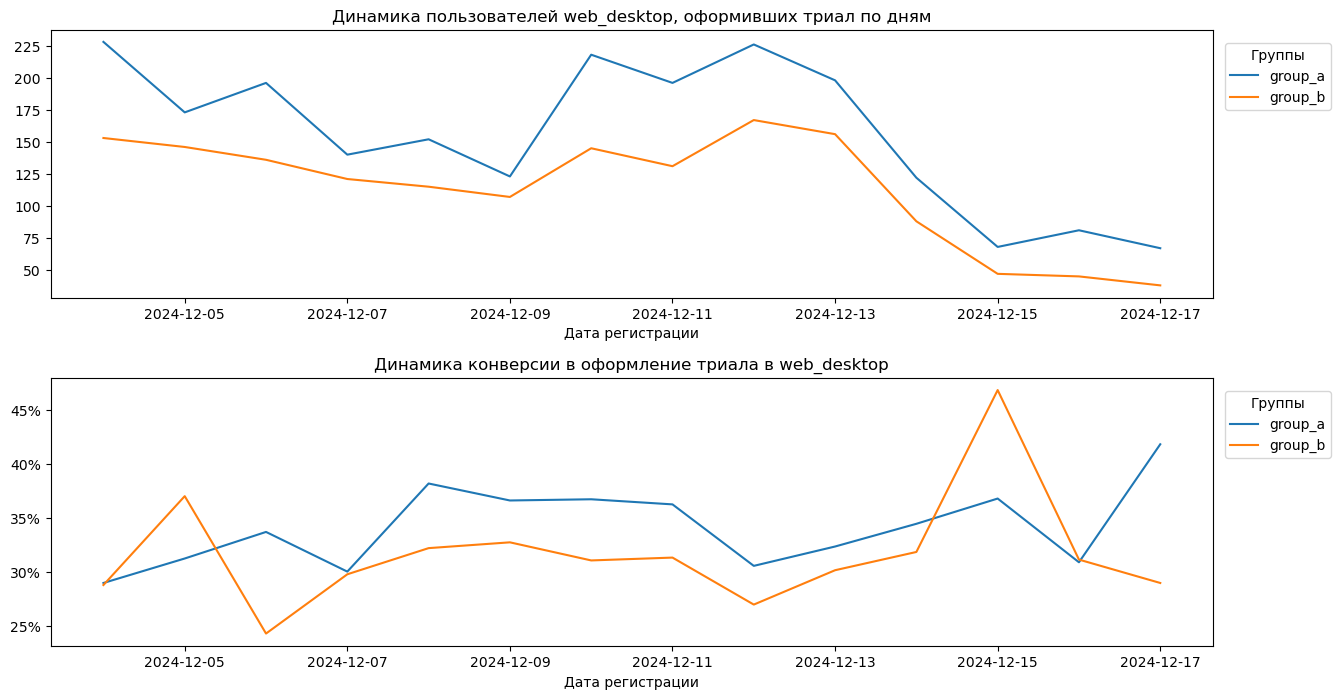

In [121]:
df_agg = test_df[test_df['client_type']=='web_desktop'].groupby(['reg_date','flags'],as_index=False).agg({'user_id':'nunique','trial_type':'sum'})
df_agg['conv'] = df_agg['trial_type']/df_agg['user_id']

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.lineplot(data=df_agg,x='reg_date',y='user_id',hue='flags', ax=ax[0])
ax[0].set_title("Динамика пользователей web_desktop, оформивших триал по дням")
ax[0].set_xlabel('Дата регистрации')
ax[0].set_ylabel('')
ax[0].legend(title='Группы',loc=(1.01,0.7))


sns.lineplot(data=df_agg,x='reg_date',y='conv',hue='flags',ax=ax[1])
ax[1].set_title("Динамика конверсии в оформление триала в web_desktop")
ax[1].set_xlabel('Дата регистрации')
ax[1].set_ylabel('')
ax[1].legend(title='Группы',loc=(1.01,0.7))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

plt.subplots_adjust(hspace=0.3)
plt.show()  

In [135]:
query = f'''
WITH users AS (SELECT 
               user_id,
               reg_date,
               created_date,
               bonus_title_new,
               client_type,
               JSONExtractString(payload,'from') AS from_payload,
               JSONExtractString(JSONExtractString(payload,'flags'),'new_button_main_page') AS flags,
               CASE WHEN created_date='1970-01-01' THEN 0 ELSE 1 END trial_type,
               max(app_version) AS app_version
               FROM
                (SELECT user_id,payload,app_version,created_at::date AS created_date,reg_date,bonus_title,client_type
                 FROM datamarts.sandbox_data_distr 
                 WHERE reg_date BETWEEN '2024-12-19' AND '2024-12-24'
                 AND user_id IS NOT NULL
                 AND client_type IN ('web_desktop','web_mobile')
                 AND event_name in ('goto_auth_page','click_auth_continue','show_login_password_page','auto_auth_success_authorization')
                 ) AS t1
                LEFT JOIN datamarts.mekhtiev_bonus_distr AS t2 ON t1.bonus_title=t2.bonus_title_old
                GROUP BY 1,2,3,4,5,6,7,8
            ),
                
---Дедуппликация пользователей с несколькими группами --------
duplicate AS (SELECT user_id,uniq(flags) AS cnt_uniq_flag
                FROM users
                WHERE flags!=''
                GROUP BY 1
                )
                
-------Убираем дубликаты и джойним ----------                
SELECT 
t1.user_id AS user_id,
reg_date,
bonus_title_new,
client_type,
from_payload,
created_date,
app_version,
trial_type,
flags
FROM users AS t1
LEFT JOIN (SELECT * FROM duplicate WHERE cnt_uniq_flag>1) AS t2 ON t1.user_id=t2.user_id
WHERE t2.user_id IS NULL
'''

df = execute(query,user='kmekhtiev')
df['reg_date'] = df['reg_date'].astype('datetime64[ns]')

Время выполнения функции: 2.6163 секунд



In [137]:
df[df['from_payload'].notna()]

,user_id,reg_date,bonus_title_new,client_type,from_payload,created_date,app_version,trial_type,flags
0,d4e3c1d8-8407-404a-bf73-b648a4ffd553,2024-12-19,,web_mobile,,2024-12-19,4.12.1-prod,1,group_a
1,0152a061-7421-4be0-9c5e-44fb97b515ea,2024-12-22,,web_mobile,,2024-12-22,4.13.0-prod,1,group_a
2,9a5818ef-07ba-4d83-a326-903fe10b5216,2024-12-19,,web_mobile,,1970-01-01,4.12.1-prod,0,group_b
3,e268f88c-1ecb-4e5b-9cc2-d1cc00c5baff,2024-12-21,Flocktory,web_mobile,,2024-12-21,4.13.0-prod,1,group_a
4,b64131bb-13a4-4881-ba04-f65d6c42843f,2024-12-22,,web_mobile,,2024-12-22,4.13.0-prod,1,group_a
...,...,...,...,...,...,...,...,...,...
379,255d2e05-8171-44f5-a32a-1c08ef1b62e8,2024-12-21,Ставропольцев,web_mobile,,2024-12-21,4.13.0-prod,1,group_b
380,306a9fdd-86e7-4b54-a8b6-4df7d34b6b78,2024-12-20,,web_mobile,,2024-12-20,4.13.0-prod,1,group_a
381,2ae99a5b-3a04-4875-a14d-f8c5c590cbdc,2024-12-23,Flocktory,web_mobile,,2024-12-23,4.13.0-prod,1,group_a
382,30278e33-151b-4250-8e79-c8faffd6a1d9,2024-12-20,,web_mobile,,2024-12-20,4.13.0-prod,1,group_a
